In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

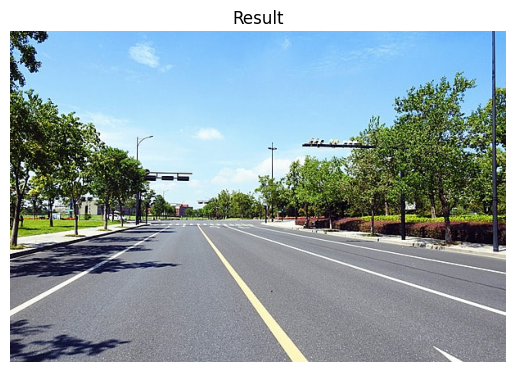

In [3]:
# Path gambar
path_gambar = '/content/drive/MyDrive/Skilvul Final Project/gambar_jalan.jpg'

# Membaca gambar
image = cv2.imread(path_gambar)

# Mengubah warna gambar dari BGR ke RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Menampilkan gambar
plt.imshow(image_rgb)
plt.title('Result')
plt.axis('off')  # Menghilangkan axis
plt.show()

In [5]:
lane_image = np.copy(image)

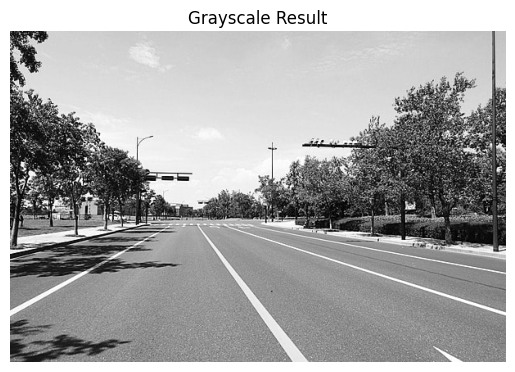

In [6]:
# Konversi ke grayscale
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

# Menampilkan gambar grayscale
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Result')
plt.axis('off')  # Menghilangkan axis
plt.show()

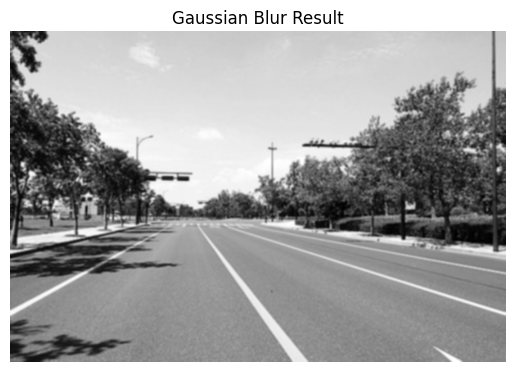

In [7]:
# Mengurangi noise dan melakukan Gaussian blur
blur = cv2.GaussianBlur(gray, (5,5), 0)

# Menampilkan gambar Gaussian blur
plt.imshow(blur, cmap='gray')
plt.title('Gaussian Blur Result')
plt.axis('off')  # Menghilangkan axis
plt.show()

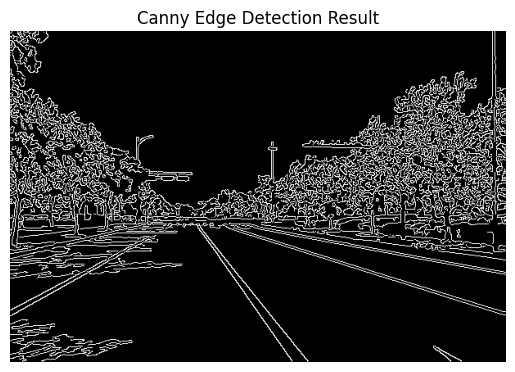

In [8]:
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

# Menampilkan hasil deteksi tepi Canny
plt.imshow(canny(lane_image), cmap='gray')
plt.title('Canny Edge Detection Result')
plt.axis('off')  # Menghilangkan axis
plt.show()

In [9]:
canny1 = canny(lane_image)

array([[  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [255, 255,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
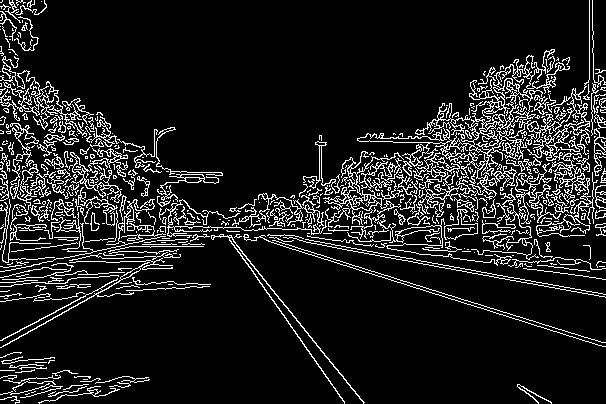

In [10]:
canny1

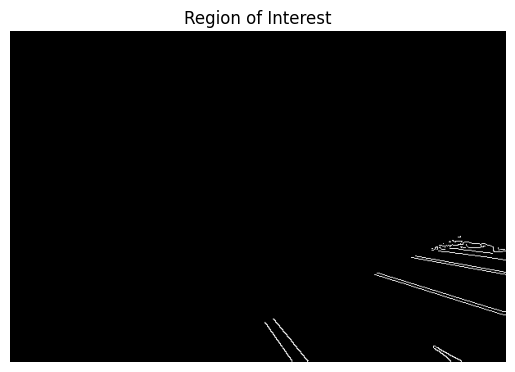

In [11]:
# Fungsi untuk region of interest
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([[(200, height), (1100, height), (550, 250)]])  # Membuat mask segitiga
    mask = np.zeros_like(image)  # Pixel hitam
    cv2.fillPoly(mask, polygons, 255)  # Mengisi mask dengan dimensi segitiga sebagai putih (255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Menerapkan deteksi tepi Canny
canny_image = canny(lane_image)

# Menerapkan region of interest
roi_image = region_of_interest(canny_image)

# Menampilkan gambar hasil region of interest
plt.imshow(roi_image, cmap='gray')
plt.title('Region of Interest')
plt.axis('off')  # Menghilangkan axis
plt.show()

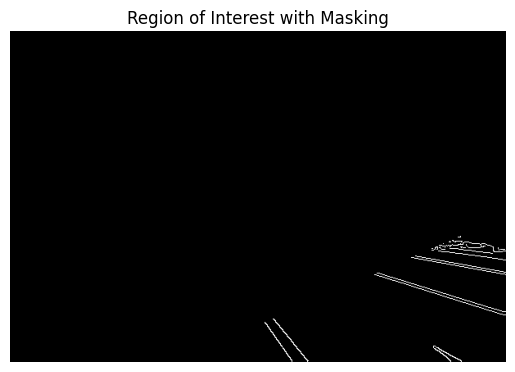

In [12]:
# Fungsi untuk region of interest dengan masking
def region_of_interest_masked(image):
    height = image.shape[0]
    polygons = np.array([[(200, height), (1100, height), (550, 250)]])  # Membuat mask segitiga
    mask = np.zeros_like(image)  # Pixel hitam
    cv2.fillPoly(mask, polygons, 255)  # Mengisi mask dengan dimensi segitiga sebagai putih (255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Menerapkan deteksi tepi Canny
canny_image = canny(lane_image)

# Menerapkan region of interest dengan masking
roi_masked_image = region_of_interest_masked(canny_image)

# Menampilkan gambar hasil region of interest dengan masking
plt.imshow(roi_masked_image, cmap='gray')
plt.title('Region of Interest with Masking')
plt.axis('off')  # Menghilangkan axis
plt.show()

In [13]:
cropped_image = region_of_interest_masked(canny1)

In [14]:
lines = cv2.HoughLinesP(cropped_image , 2 , np.pi/180 , 100 , np.array([]), minLineLength = 40 , maxLineGap = 5)

#averaged_lines = average_slope_intercept()

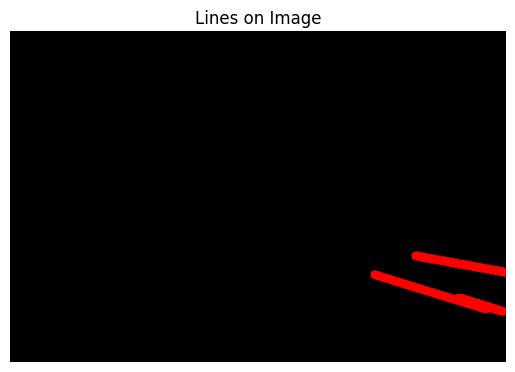

In [15]:
# Fungsi untuk menampilkan garis
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

# Menerapkan deteksi tepi Canny
canny_image = canny(lane_image)

# Menerapkan region of interest dengan masking
roi_masked_image = region_of_interest_masked(canny_image)

# Menggunakan Hough Transform untuk mendeteksi garis
lines = cv2.HoughLinesP(roi_masked_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

# Menampilkan garis pada gambar asli
line_image = display_lines(lane_image, lines)

# Menampilkan gambar hasil garis dengan masking menggunakan matplotlib
plt.imshow(line_image)
plt.title('Lines on Image')
plt.axis('off')  # Menghilangkan axis
plt.show()

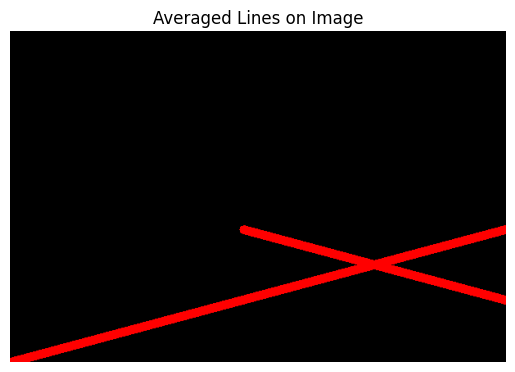

In [16]:
# Fungsi untuk membuat koordinat garis dari parameter garis
def make_cordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (3 / 5))

    # Menghindari pembagian dengan nol
    if slope == 0:
        x1 = 0
        x2 = image.shape[1] - 1
    else:
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)

    return np.array([x1, y1, x2, y2])

# Fungsi untuk menghitung rata-rata kemiringan dan intercept serta membuat garis
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []

    if lines is None:
        return np.array([])  # Mengembalikan array kosong jika tidak ada garis

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))

    # Menangani kasus di mana tidak ada garis kiri atau kanan
    if len(left_fit) == 0:
        left_fit_average = [0, 0]
    else:
        left_fit_average = np.average(left_fit, axis=0)

    if len(right_fit) == 0:
        right_fit_average = [0, 0]
    else:
        right_fit_average = np.average(right_fit, axis=0)

    left_line = make_cordinates(image, left_fit_average)
    right_line = make_cordinates(image, right_fit_average)

    return np.array([left_line, right_line])

# Menerapkan deteksi tepi Canny
canny_image = canny(lane_image)

# Menerapkan region of interest dengan masking
roi_masked_image = region_of_interest_masked(canny_image)

# Menggunakan Hough Transform untuk mendeteksi garis
lines = cv2.HoughLinesP(roi_masked_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

# Menghitung rata-rata kemiringan dan intercept, dan membuat garis
averaged_lines = average_slope_intercept(lane_image, lines)

# Menampilkan hasil garis pada gambar asli
line_image = display_lines(lane_image, averaged_lines)

# Menampilkan gambar hasil garis dengan masking menggunakan matplotlib
plt.imshow(line_image)
plt.title('Averaged Lines on Image')
plt.axis('off')  # Menghilangkan axis
plt.show()

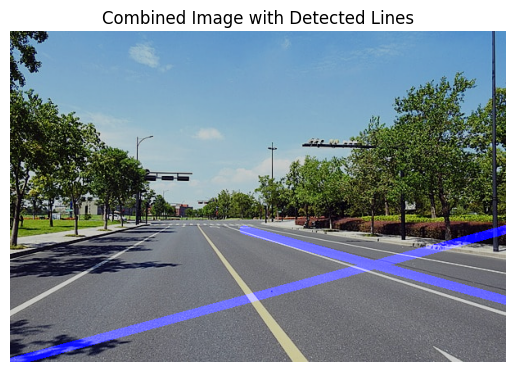

In [17]:
# Fungsi untuk menampilkan garis pada gambar
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

# Menghitung garis rata-rata dan menampilkan
line_image = display_lines(lane_image, averaged_lines)

# Menggabungkan gambar lane_image dan line_image dengan alpha blending
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 0)

# Mengonversi gambar dari BGR ke RGB untuk tampilan dengan matplotlib
combo_image_rgb = cv2.cvtColor(combo_image, cv2.COLOR_BGR2RGB)

# Menampilkan gambar dengan matplotlib
plt.imshow(combo_image_rgb)
plt.title('Combined Image with Detected Lines')
plt.axis('off')  # Menghilangkan sumbu
plt.show()

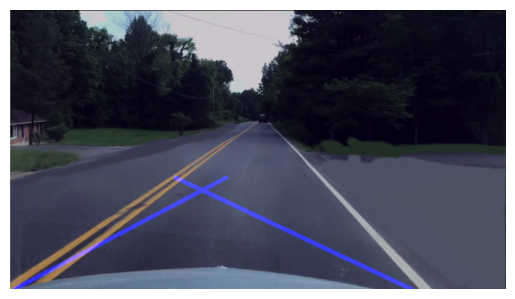

In [ ]:
# Fungsi untuk memproses dan menampilkan video
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break

        # Proses frame
        canny1 = canny(frame)
        cropped_image = region_of_interest_masked(canny1)
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi / 180, 100, np.array([]), minLineLength=40, maxLineGap=5)
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(frame, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 0)

        # Konversi gambar dari BGR ke RGB
        combo_image_rgb = cv2.cvtColor(combo_image, cv2.COLOR_BGR2RGB)

        # Tampilkan gambar dengan matplotlib
        plt.imshow(combo_image_rgb)
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)

    cap.release()
    cv2.destroyAllWindows()

# Ganti dengan path video Anda
path_video = '/content/drive/MyDrive/Skilvul Final Project/video_jalan.mp4'
process_video(path_video)
